<a href="https://colab.research.google.com/github/mohamedfadul/DeepSearch-Finding-Truncated-Differential-Trails-Using-Genetic-Algorithms-and-Deep-Learning/blob/main/ML_Regression_Baseline_Models_for_S_Boxes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [25]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.0


In [27]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [29]:
train_dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Exp5 Data/baseline.csv')
test_dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Exp5 Data/TWINE.csv')

In [30]:
train_dataset

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,...,perm7,perm8,perm9,perm10,perm11,perm12,perm13,perm14,perm15,perm16
0,0,0,0,1,0,1,0,0,0,0,...,15,8,3,12,1,10,7,0,13,14
1,0,1,0,0,0,1,0,0,0,1,...,15,8,3,12,1,10,7,0,13,14
2,0,0,0,0,0,1,0,0,0,1,...,15,8,3,12,1,10,7,0,13,14
3,0,0,0,1,0,1,0,0,0,1,...,15,8,3,12,1,10,7,0,13,14
4,0,1,0,1,0,1,0,0,0,0,...,15,8,3,12,1,10,7,0,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500338,0,1,1,1,1,1,0,1,1,1,...,3,6,15,0,9,10,1,14,5,12
500339,0,1,1,1,1,1,0,1,1,1,...,3,6,15,0,9,10,1,14,5,12
500340,0,1,1,1,1,1,0,1,1,1,...,3,6,15,0,9,10,1,14,5,12
500341,0,1,1,1,1,1,0,1,1,1,...,3,6,15,0,9,10,1,14,5,12


In [31]:
test_dataset

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,...,perm7,perm8,perm9,perm10,perm11,perm12,perm13,perm14,perm15,perm16
0,0,1,0,1,0,0,1,1,1,1,...,3,8,13,6,9,2,15,10,11,14
1,0,1,0,1,0,0,1,1,1,1,...,3,8,13,6,9,2,15,10,11,14
2,0,1,0,1,0,0,1,1,1,1,...,3,8,13,6,9,2,15,10,11,14
3,0,1,0,1,0,0,1,1,1,1,...,3,8,13,6,9,2,15,10,11,14
4,0,0,1,0,0,0,0,0,1,0,...,3,8,13,6,9,2,15,10,11,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0,1,1,1,1,1,1,0,...,3,8,13,6,9,2,15,10,11,14
99996,0,1,0,1,1,1,1,1,1,0,...,3,8,13,6,9,2,15,10,11,14
99997,0,1,0,1,1,1,1,1,1,0,...,3,8,13,6,9,2,15,10,11,14
99998,0,1,0,1,1,1,1,1,1,0,...,3,8,13,6,9,2,15,10,11,14


In [32]:
train_labels = train_dataset.pop("sboxes")

In [33]:
test_labels = test_dataset.pop("sboxes")

In [34]:
Scaled_test_labels = test_dataset.pop("scaledsboxes")

In [35]:
from sklearn.preprocessing import  StandardScaler
sc =  StandardScaler()
normed_train_data = pd.DataFrame(sc.fit_transform(train_dataset),columns=train_dataset.columns)
normed_test_data = pd.DataFrame(sc.fit_transform(test_dataset),columns=test_dataset.columns)

In [36]:
def r2_score_tf(y, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y = tf.cast(y, y_pred.dtype)
  residual = tf.reduce_sum(tf.square(tf.subtract(y,y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  return 1 - (residual / total)

In [37]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
  gradients = K.gradients(y_pred, averaged_samples)[0]
  try:
    gradients_sqr = K.square(gradients)
  except ValueError:
    print("Gradients returned None")
    return 0
  gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
  gradient_l2_norm = K.sqrt(gradients_sqr_sum)

  gradient_penalty = K.square(1 - gradient_l2_norm)

  return K.mean(gradient_penalty)

In [38]:
def quantile(self, y_true, y_pred):
        logits_pred = y_pred
        theta_target = y_true

        theta_pred = tf.reduce_sum(tf.multiply(self.action_binary_loss , logits_pred), axis=1)

        theta_target_tile = tf.tile(tf.expand_dims(theta_target, axis=2), [1, 1, self.n_quantiles])
        theta_pred_tile = tf.tile(tf.expand_dims(theta_pred, axis=1), [1, self.n_quantiles, 1])

        error_loss = self.theta_target_tile - self.theta_pred_tile
        huber_loss = self.HuberLoss(theta_target_tile, theta_pred_tile)

        min_tau = 1 / (2 * self.n_quantiles)
        max_tau = (2*self.n_quantiles +1) / (2*self.n_quantiles)

        tau = tf.reshape(tf.range(min_tau, max_tau, 1/self.n_quantiles), [1, self.n_quantiles])
        inv_tau = 1.0 - tau

        Loss = tf.where(tf.less(error_loss, 0.0), inv_tau * huber_loss, tau* huber_loss)
        Loss = tf.reduce_mean(tf.reduce_sum(tf.reduce_mean(Loss, axis=2), axis=1))

        return Loss

In [39]:
def above_percentile(x, p): #assuming the input is flattened: (n,)

    samples = K.cast(K.shape(x)[0], K.floatx()) #batch size
    p =  (100. - p)/100.  #100% will return 0 elements, 0% will return all elements

    #samples to get:
    samples = K.cast(tf.math.floor(p * samples), 'int32')
        #you can choose tf.math.ceil above, it depends on whether you want to
        #include or exclude one element. Suppose you you want 33% top,
        #but it's only possible to get exactly 30% or 40% top:
        #floor will get 30% top and ceil will get 40% top.
        #(exact matches included in both cases)

    #selected samples
    values, indices = tf.math.top_k(x, samples)

    return values

def custom_loss(p):
    def loss(y_true, y_predicted):
        y_predicted = ops.convert_to_tensor_v2(y_predicted)
        y_true = math_ops.cast(y_true, y_predicted.dtype)
        ses = K.square(y_true-y_predicted)
        above = above_percentile(K.flatten(ses), p)
        return K.mean(above)
    return loss

In [40]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [41]:
#Linear regression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [42]:
#from sklearn.svm import SVR
#from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming train_dataset, test_dataset, train_labels, test_labels are defined

# Create and train SVR
#svr_model = SVR(kernel='rbf')  # You can choose different kernels like 'linear', 'poly', etc.
#svr_model.fit(train_dataset, train_labels)

# Predict on test dataset
#y_pred_svr = svr_model.predict(test_dataset)

# Calculate metrics
#mse_svr = mean_squared_error(test_labels, y_pred_svr)
#rmse_svr = mean_squared_error(test_labels, y_pred_svr, squared=False)  # Compute RMSE
#mae_svr = mean_absolute_error(test_labels, y_pred_svr)

#print('Mean squared error from SVR:', mse_svr)
#print('Root mean squared error from SVR:', rmse_svr)
#print('Mean absolute error from SVR:', mae_svr)

In [43]:
#svr_predictions = svr_model.predict(test_dataset).flatten()

#a = plt.axes(aspect='equal')
#plt.scatter(test_labels, svr_predictions)
#plt.xlabel('True Values [ActiveSboxes]')
#plt.ylabel('Predictions [ActiveSboxes]')
#lims = [0, 100]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)
#plt.savefig('toy cipher baseline RMSE.png')
#plt.savefig('toy cipher baseline RMSE.pdf')

In [44]:
### Decision tree
tree = DecisionTreeRegressor()
tree.fit(normed_train_data, train_labels)
y_pred_tree = tree.predict(normed_test_data)
#mse_dt = mean_squared_error(test_labels, y_pred_tree)
rmse_dt = root_mean_squared_error(test_labels, y_pred_tree)
#mae_dt = mean_absolute_error(test_labels, y_pred_tree)
r2_dt = r2_score_tf(test_labels, y_pred_tree)
print('R2 using Decision Tree: ', r2_dt)
print('Root Mean squared error from Decision Tree: ', rmse_dt)

R2 using Decision Tree:  tf.Tensor(0.7286229949634365, shape=(), dtype=float64)
Root Mean squared error from Decision Tree:  tf.Tensor(6.777158163845505, shape=(), dtype=float64)


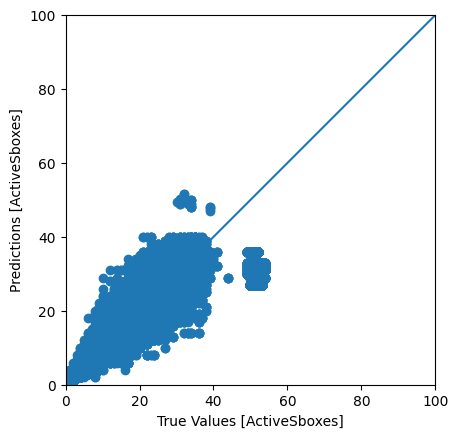

In [45]:
tree_predictions = tree.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, tree_predictions)
plt.xlabel('True Values [ActiveSboxes]')
plt.ylabel('Predictions [ActiveSboxes]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('toy cipher baseline RMSE.png')
plt.savefig('toy cipher baseline RMSE.pdf')

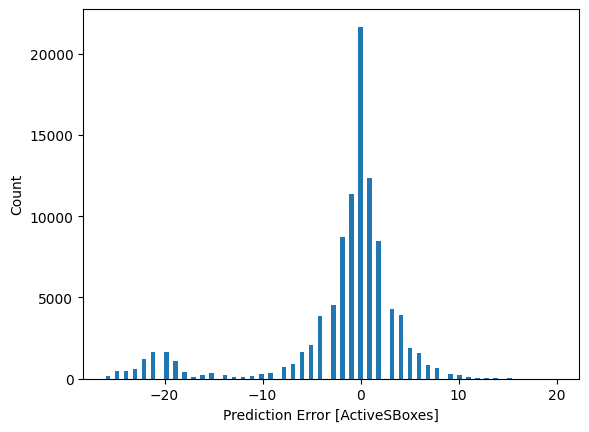

In [46]:
error = round(tree_predictions - test_labels)
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [ActiveSBoxes]")
_ = plt.ylabel("Count")

In [54]:
#Random forest.
#Increase number of tress and see the effect
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 50, random_state=50)
forest.fit(normed_train_data, train_labels)

y_pred_RF = forest.predict(normed_test_data)

#mse_RF = mean_squared_error(test_labels, y_pred_RF)
rmse_RF = root_mean_squared_error(test_labels, y_pred_RF)
#mae_RF = mean_absolute_error(test_labels, y_pred_RF)
#print('Mean squared error using Random Forest: ', mse_RF)
r2_RF = r2_score_tf(test_labels, y_pred_RF)
print('R2 using decision tree: ', r2_RF)
print('Root Mean squared error from Random Forest: ', rmse_RF)

R2 using decision tree:  tf.Tensor(0.7947632333702863, shape=(), dtype=float64)
Root Mean squared error from Random Forest:  tf.Tensor(5.8937088879022115, shape=(), dtype=float64)


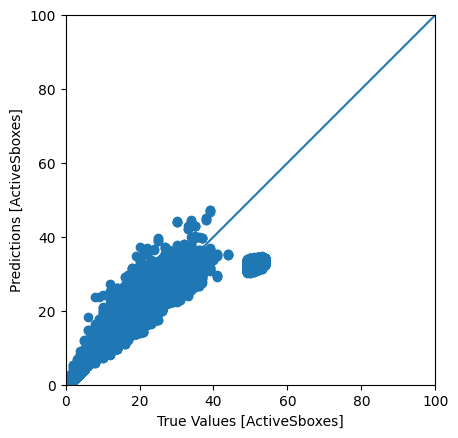

In [48]:
forest_predictions = forest.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, forest_predictions)
plt.xlabel('True Values [ActiveSboxes]')
plt.ylabel('Predictions [ActiveSboxes]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('toy cipher baseline RMSE.png')
plt.savefig('toy cipher baseline RMSE.pdf')

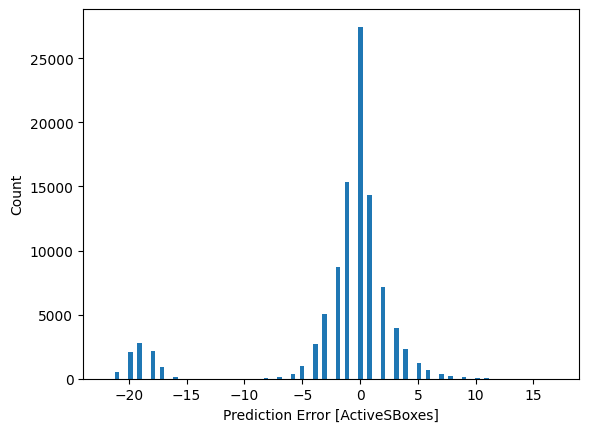

In [49]:
error = round(forest_predictions - test_labels)
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [ActiveSBoxes]")
_ = plt.ylabel("Count")

In [50]:
#Feature ranking...
import pandas as pd
feature_list = list(normed_train_data.columns)
feature_imp = pd.Series(forest.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)

rounds      9.246850e-01
input13     1.253314e-02
input3      1.201248e-02
input10     4.880457e-03
input2      4.201417e-03
input5      3.120795e-03
input9      3.022133e-03
input11     2.898592e-03
input8      2.503382e-03
output12    1.906709e-03
input6      1.767400e-03
input16     1.758002e-03
input7      1.448588e-03
output14    1.427632e-03
input15     1.422864e-03
output10    1.421177e-03
output4     1.401195e-03
output16    1.392294e-03
output6     1.385998e-03
output2     1.313055e-03
input14     1.283668e-03
output8     1.282238e-03
input4      1.180025e-03
input12     1.109955e-03
perm13      7.710426e-04
perm5       7.406209e-04
output5     6.636079e-04
perm9       6.173985e-04
output3     6.128391e-04
output1     6.081453e-04
output7     5.654678e-04
output9     4.788804e-04
output11    4.506375e-04
output13    4.237208e-04
output15    4.144313e-04
perm11      3.836121e-04
perm12      3.690152e-04
perm7       2.890773e-04
perm16      2.705100e-04
perm1       2.595942e-04


In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming train_dataset, test_dataset, train_labels, test_labels are defined

# Create and train KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors as needed
knn_model.fit(normed_train_data, train_labels)

# Predict on test dataset
y_pred_knn = knn_model.predict(normed_test_data)

# Calculate metrics
#mse_knn = mean_squared_error(test_labels, y_pred_knn)
rmse_knn = root_mean_squared_error(test_labels, y_pred_knn)  # Compute RMSE
r2_knn = r2_score_tf(test_labels, y_pred_knn)

#print('Mean squared error from KNeighborsRegressor:', mse_knn)
print('R2 using KNeighborsRegressor:', r2_knn)
print('Root mean squared error from KNeighborsRegressor:', rmse_knn)

R2 using KNeighborsRegressor: tf.Tensor(0.6912561672711592, shape=(), dtype=float64)
Root mean squared error from KNeighborsRegressor: tf.Tensor(7.228700713129573, shape=(), dtype=float64)


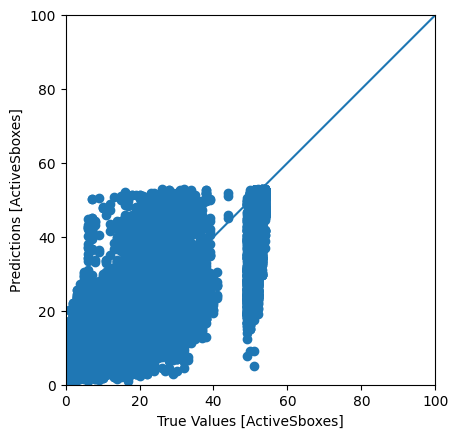

In [52]:
knn_predictions = knn_model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, knn_predictions)
plt.xlabel('True Values [ActiveSboxes]')
plt.ylabel('Predictions [ActiveSboxes]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('toy cipher baseline RMSE.png')
plt.savefig('toy cipher baseline RMSE.pdf')

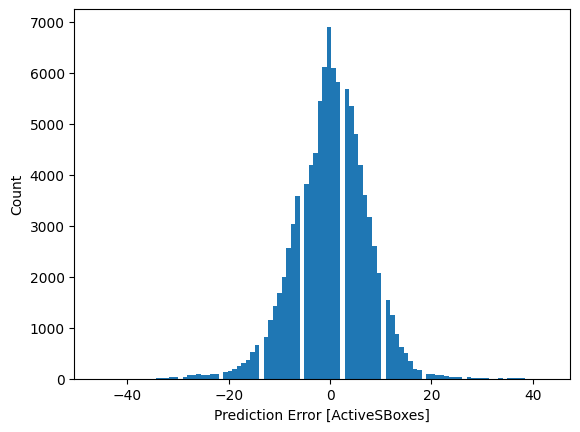

In [53]:
error = round(knn_predictions - test_labels)
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [ActiveSBoxes]")
_ = plt.ylabel("Count")